# A Tractable Model of Buﬀer Stock Saving
<p style="text-align: center;"><small><small>Generator: TractableBufferStockModel</small></small></p>

This notebook uses the [Econ-ARK/HARK](https://github.com/econ-ark/hark) toolkit to describe the main results and reproduce the figures in the paper [A Tractable Model of Buffer Stock Saving](http://www.econ2.jhu.edu/people/ccarroll/papers/ctDiscrete/)


If you are not familiar with the HARK toolkit, you may wish to browse the ["Gentle Introduction to HARK"](https://mybinder.org/v2/gh/econ-ark/DemARK/master?filepath=Gentle-Intro-To-HARK.ipynb) before continuing (since you are viewing this document, you presumably know a bit about [Jupyter Notebooks](https://jupyter-notebook-beginner-guide.readthedocs.io/en/latest/)).

For instructions on how to install the [Econ-ARK/HARK](https://github.com/econ-ark/hark) toolkit on your computer, please refer to the [QUICK START GUIDE](https://github.com/econ-ark/HARK/blob/master/README.md). 

The main HARK tool used here is $\texttt{TractableBufferStockModel.py}$, in which agents have CRRA utility and face only a very particular sort of risk: the possibility that he will become permanently unemployed until
the day he dies.

In [1]:
# This cell does some setup and imports generic tools used to produce the figures

Generator=False # Is this notebook the master or is it generated?
# Import related generic python packages
import numpy as np
from time import clock
mystr = lambda number : "{:.4f}".format(number)

# This is a jupytext paired notebook that autogenerates BufferStockTheory.py
# which can be executed from a terminal command line via "ipython BufferStockTheory.py"
# But a terminal does not permit inline figures, so we need to test jupyter vs terminal
# Google "how can I check if code is executed in the ipython notebook"

from IPython import get_ipython # In case it was run from python instead of ipython
def in_ipynb():
    try:
        if str(type(get_ipython())) == "<class 'ipykernel.zmqshell.ZMQInteractiveShell'>":
            return True
        else:
            return False
    except NameError:
        return False

# Determine whether to make the figures inline (for spyder or jupyter)
# vs whatever is the automatic setting that will apply if run from the terminal
if in_ipynb():
    # %matplotlib inline generates a syntax error when run from the shell
    # so do this instead
    get_ipython().run_line_magic('matplotlib', 'inline')
else:
    get_ipython().run_line_magic('matplotlib', 'auto')
    print('You appear to be running from a terminal')
    print('By default, figures will appear one by one')
    print('Close the visible figure in order to see the next one')

# Import the plot-figure library matplotlib

import matplotlib.pyplot as plt

# In order to use LaTeX to manage all text layout in our figures, we import rc settings from matplotlib.
from matplotlib import rc
plt.rc('font', family='serif')

# LaTeX is huge and takes forever to install on mybinder
# so if it is not installed then do not use it 
from distutils.spawn import find_executable
iflatexExists=False
if find_executable('latex'):
    iflatexExists=True
    
plt.rc('font', family='serif')
plt.rc('text', usetex=iflatexExists)

# The warnings package allows us to ignore some harmless but alarming warning messages
import warnings
warnings.filterwarnings("ignore")

# The tools for navigating the filesystem
import sys
import os

sys.path.insert(0, os.path.abspath('../../lib')) # REMARKs directory is two down from root 

from HARK.utilities import plotFuncsDer, plotFuncs
from copy import copy, deepcopy

# Define (and create, if necessary) the figures directory "Figures"
if Generator:
    my_file_path = os.path.dirname(os.path.abspath("TractbleBufferStockModel.ipynb")) # Find pathname to this file:
    Figures_HARK_dir = os.path.join(my_file_path,"Figures/") # LaTeX document assumes figures will be here
    Figures_HARK_dir = os.path.join(my_file_path,"/tmp/Figures/") # Uncomment to make figures outside of git path
    if not os.path.exists(Figures_HARK_dir):
        os.makedirs(Figures_HARK_dir)

## [The Decision Problem](http://www.econ2.jhu.edu/people/ccarroll/papers/ctDiscrete/) 

The paper defines and calibrates a small set of parameters (see Table 1 for details):

| Parameter | Description | Code | Value |
| :---: | ---         | ---  | :---: |
| $\newcommand{\PermGroFac}{\mathsf{G}}\PermGroFac$ | Permanent Income Growth Factor | $\texttt{PermGroFac}$ | 1.01 |
| $\newcommand{\Rfree}{\mathrm{\mathsf{R}}}\Rfree$ | Interest Factor | $\texttt{Rfree}$ | 1.03 |
| $\newcommand{\DiscFac}{\beta}\DiscFac$ | Time Preference Factor | $\texttt{DiscFac}$ | 0.909 |
| $\newcommand{\CRRA}{\rho}\CRRA$ | Coeﬃcient of Relative Risk Aversion| $\texttt{CRRA}$ | 2 |
| $\newcommand{\UnempPrb}{\wp}\UnempPrb$ | Probability of Unemployment | $\texttt{UnempPrb}$ | 0.005 |
|

For a microeconomic consumer with 'Market Resources' (net worth plus current income) $m_{t}$, end-of-period assets $a_{t}$ will be the amount remaining after consumption of $c_{t}$.  <!-- Next period's 'Balances' $b_{t+1}$ reflect this period's $a_{t}$ augmented by return factor $R$:-->
\begin{eqnarray}
a_{t}   &=&m_{t}-c_{t}  \label{eq:DBCparts} \\
%b_{t+1}   & = & a_{t} R \notag \\
\end{eqnarray}

The consumer's aggregate wage rate $W_{t}$ grows by a constant factor $G$ from the current time period to the next, reflecting exogenous productivity growth: 
\begin{eqnarray}
W_{t+1} & = & W_{t} G
\end{eqnarray}

$\ell$ measures the consumer’s labor productivity (hours of work for an employed consumer are assumed to be exogenous and fixed) and $\xi$ is a dummy variable indicating the consumer’s employment state: Everyone in this economy is either employed ($\xi = 1$, a state indicated by the letter ‘$e$’) or unemployed ($\xi = 0$, a state indicated by ‘$u$’), so that next period's market resources are:
\begin{eqnarray}
%m_{t+1} &=& b_{t+1} +W_{t+1} \ell_{t+1} \xi_{t+1},  \notag
m_{t+1} &=& a_{t}R + W_{t+1} \ell_{t+1} \xi_{t+1}.  \notag
\end{eqnarray}

When the consumer has a CRRA utility function $u(c)=\frac{c^{1-\rho}}{1-\rho}$, the paper shows that the Bellman form of problem is:

\begin{eqnarray*}
v_t(m_t) &=& \max_{c_t}~u(c_t) + \beta \left((1-\wp)v_{t+1}^{e}(m_{t+1})+\wp v_{t+1}^{u}(m_{t+1})\right), \\
& s.t. & \\
a_t &=& m_t - c_t, \\
m_{t+1} &=& R a_t + \ell_{t+1}\xi_{t+1}W_{t+1}
\end{eqnarray*}


In [2]:
# Define a parameter dictionary with baseline parameter values

# Set the baseline parameter values 
TBS_dictionary = {
        'CRRA': 2.0,          # The dictionary includes our original parameters...
        'Rfree': 1.03,
        'DiscFac': 1/1.1,
        'LivPrb': [1.0],
        'PermGroFac': 1.0/(1-0.005),
        'PermShkStd': [0.],   # no permanent shocks for our agent...    
        'PermShkCount': 1.,
        'TranShkStd': [0.],
        'TranShkCount': 0,
        'UnempPrb': 0.005,
        'IncUnemp': 0.,
        'BoroCnstArt': 0.0,
        'aXtraMin': 0.001,    # aXtra parameters specify how to construct the grid of assets.
        'aXtraMax': 0.5,      # Don't worry about these for now
        'aXtraNestFac': 3,
        'aXtraCount': 0,
        'aXtraExtra': [None],
        'vFuncBool': False,   # These booleans indicate whether the value function should be calculated
        'CubicBool': False,   # and whether to use cubic spline interpolation. You can ignore them.
        'aNrmInitMean' : 0.,
        'aNrmInitStd' : 0.0,  # These parameters specify the (log) distribution of normalized assets
        'pLvlInitMean' : 1.5, # and permanent income for agents at "birth". They are only relevant in
        'pLvlInitStd' : 0.,   # simulation and you don't need to worry about them.
        'PermGroFacAgg' : 0.,
        'T_retire': 0,        
        'UnempPrbRet': 0.0,   
        'IncUnempRet': 0.0, 
        'T_age' : None,
        'T_cycle' : 1,
        'cycles' : 0, #consumer is infinitely lived
        'AgentCount': 1,
        'tax_rate':0.0,
    }

In [3]:
# from HARK.ConsumptionSaving.TractableBufferStockModel import TractableConsumerType
# The code below is what you get if you exeute the command on the prior line
# from a location where HARK is accessible.  It is included here because the
# latest pip-installable version of HARK does not include the impatience conditions
# (though the online one does)

from __future__ import division, print_function
from __future__ import absolute_import
from builtins import str
import numpy as np

# Import the HARK library.
from HARK import AgentType, NullFunc, Solution
from HARK.utilities import warnings  # Because of "patch" to warnings modules
from HARK.utilities import CRRAutility, CRRAutilityP, CRRAutilityPP, CRRAutilityPPP, CRRAutilityPPPP, CRRAutilityP_inv, CRRAutility_invP, CRRAutility_inv
from HARK.interpolation import CubicInterp
from HARK.simulation import drawLognormal, drawBernoulli
from copy import copy
from scipy.optimize import newton, brentq

# If you want to run the "tractable" version of cstwMPC, uncomment the line below
# and have TractableConsumerType inherit from cstwMPCagent rather than AgentType
#from HARK.cstwMPC.cstwMPC import cstwMPCagent

# Define utility function and its derivatives (plus inverses)
utility = CRRAutility
utilityP = CRRAutilityP
utilityPP = CRRAutilityPP
utilityPPP = CRRAutilityPPP
utilityPPPP = CRRAutilityPPPP
utilityP_inv = CRRAutilityP_inv
utility_invP = CRRAutility_invP
utility_inv = CRRAutility_inv

class TractableConsumerSolution(Solution):
    '''
    A class representing the solution to a tractable buffer saving problem.
    Attributes include a list of money points mNrm_list, a list of consumption points
    cNrm_list, a list of MPCs MPC_list, a perfect foresight consumption function
    while employed, and a perfect foresight consumption function while unemployed.
    The solution includes a consumption function constructed from the lists.
    '''
    def __init__(self, mNrm_list=[], cNrm_list=[], MPC_list=[], cFunc_U=NullFunc, cFunc=NullFunc):
        '''
        The constructor for a new TractableConsumerSolution object.

        Parameters
        ----------
        mNrm_list : [float]
            List of normalized market resources points on the stable arm.
        cNrm_list : [float]
            List of normalized consumption points on the stable arm.
        MPC_list : [float]
            List of marginal propensities to consume on the stable arm, corres-
            ponding to the (mNrm,cNrm) points.
        cFunc_U : function
            The (linear) consumption function when permanently unemployed.
        cFunc : function
            The consumption function when employed.

        Returns
        -------
        new instance of TractableConsumerSolution
        '''
        self.mNrm_list = mNrm_list
        self.cNrm_list = cNrm_list
        self.MPC_list = MPC_list
        self.cFunc_U = cFunc_U
        self.cFunc = cFunc
        self.distance_criteria = ['PointCount']
        # The distance between two solutions is the difference in the number of
        # stable arm points in each.  This is a very crude measure of distance
        # that captures the notion that the process is over when no points are added.

def findNextPoint(DiscFac,Rfree,CRRA,PermGroFacCmp,UnempPrb,Rnrm,Beth,cNext,mNext,MPCnext,PFMPC):
    '''
    Calculates what consumption, market resources, and the marginal propensity
    to consume must have been in the previous period given model parameters and
    values of market resources, consumption, and MPC today.

    Parameters
    ----------
    DiscFac : float
        Intertemporal discount factor on future utility.
    Rfree : float
        Risk free interest factor on end-of-period assets.
    PermGroFacCmp : float
        Permanent income growth factor, compensated for the possibility of
        permanent unemployment.
    UnempPrb : float
        Probability of becoming permanently unemployed.
    Rnrm : float
        Interest factor normalized by compensated permanent income growth factor.
    Beth : float
        Damned if I know.
    cNext : float
        Normalized consumption in the succeeding period.
    mNext : float
        Normalized market resources in the succeeding period.
    MPCnext : float
        The marginal propensity to consume in the succeeding period.
    PFMPC : float
        The perfect foresight MPC; also the MPC when permanently unemployed.

    Returns
    -------
    mNow : float
        Normalized market resources this period.
    cNow : float
        Normalized consumption this period.
    MPCnow : float
        Marginal propensity to consume this period.
    '''
    uPP = lambda x : utilityPP(x,gam=CRRA)
    cNow = PermGroFacCmp*(DiscFac*Rfree)**(-1.0/CRRA)*cNext*(1 + UnempPrb*((cNext/(PFMPC*(mNext-1.0)))**CRRA-1.0))**(-1.0/CRRA)
    mNow = (PermGroFacCmp/Rfree)*(mNext - 1.0) + cNow
    cUNext = PFMPC*(mNow-cNow)*Rnrm
    natural = Beth*Rnrm*(1.0/uPP(cNow))*((1.0-UnempPrb)*uPP(cNext)*MPCnext + UnempPrb*uPP(cUNext)*PFMPC)
    MPCnow = natural / (natural + 1)
    return mNow, cNow, MPCnow


def addToStableArmPoints(solution_next,DiscFac,Rfree,CRRA,PermGroFacCmp,UnempPrb,PFMPC,Rnrm,Beth,mLowerBnd,mUpperBnd):
    '''
    Adds a one point to the bottom and top of the list of stable arm points if
    the bounding levels of mLowerBnd (lower) and mUpperBnd (upper) have not yet
    been met by a stable arm point in mNrm_list.  This acts as the "one period
    solver" / solveOnePeriod in the tractable buffer stock model.

    Parameters
    ----------
    solution_next : TractableConsumerSolution
        The solution object from the previous iteration of the backshooting
        procedure.  Not the "next period" solution per se.
    DiscFac : float
        Intertemporal discount factor on future utility.
    Rfree : float
        Risk free interest factor on end-of-period assets.
    CRRA : float
        Coefficient of relative risk aversion.
    PermGroFacCmp : float
        Permanent income growth factor, compensated for the possibility of
        permanent unemployment.
    UnempPrb : float
        Probability of becoming permanently unemployed.
    PFMPC : float
        The perfect foresight MPC; also the MPC when permanently unemployed.
    Rnrm : float
        Interest factor normalized by compensated permanent income growth factor.
    Beth : float
        Damned if I know.
    mLowerBnd : float
        Lower bound on market resources for the backshooting process.  If
        min(solution_next.mNrm_list) < mLowerBnd, no new bottom point is found.
    mUpperBnd : float
        Upper bound on market resources for the backshooting process.  If
        max(solution_next.mNrm_list) > mUpperBnd, no new top point is found.

    Returns:
    ---------
    solution_now : TractableConsumerSolution
        A new solution object with new points added to the top and bottom.  If
        no new points were added, then the backshooting process is about to end.
    '''
    # Unpack the lists of Euler points
    mNrm_list = copy(solution_next.mNrm_list)
    cNrm_list = copy(solution_next.cNrm_list)
    MPC_list = copy(solution_next.MPC_list)

    # Check whether to add a stable arm point to the top
    mNext = mNrm_list[-1]
    if mNext < mUpperBnd:
        # Get the rest of the data for the previous top point
        cNext = solution_next.cNrm_list[-1]
        MPCNext = solution_next.MPC_list[-1]

        # Calculate employed levels of c, m, and MPC from next period's values
        mNow, cNow, MPCnow = findNextPoint(DiscFac,Rfree,CRRA,PermGroFacCmp,UnempPrb,Rnrm,Beth,cNext,mNext,MPCNext,PFMPC)

        # Add this point to the top of the stable arm list
        mNrm_list.append(mNow)
        cNrm_list.append(cNow)
        MPC_list.append(MPCnow)

    # Check whether to add a stable arm point to the bottom
    mNext = mNrm_list[0]
    if mNext > mLowerBnd:
        # Get the rest of the data for the previous bottom point
        cNext = solution_next.cNrm_list[0]
        MPCNext = solution_next.MPC_list[0]

        # Calculate employed levels of c, m, and MPC from next period's values
        mNow, cNow, MPCnow = findNextPoint(DiscFac,Rfree,CRRA,PermGroFacCmp,UnempPrb,Rnrm,Beth,cNext,mNext,MPCNext,PFMPC)

        # Add this point to the top of the stable arm list
        mNrm_list.insert(0,mNow)
        cNrm_list.insert(0,cNow)
        MPC_list.insert(0,MPCnow)

    # Construct and return this period's solution
    solution_now = TractableConsumerSolution(mNrm_list=mNrm_list, cNrm_list=cNrm_list, MPC_list=MPC_list)
    solution_now.PointCount = len(mNrm_list)
    return solution_now


class TractableConsumerType(AgentType):

    def __init__(self,cycles=0,time_flow=False,**kwds):
        '''
        Instantiate a new TractableConsumerType with given data.

        Parameters
        ----------
        cycles : int
            Number of times the sequence of periods should be solved.
        time_flow : boolean
            Whether time is currently "flowing" forward for this instance.

        Returns:
        -----------
        New instance of TractableConsumerType.
        '''
        # Initialize a basic AgentType
        AgentType.__init__(self,cycles=cycles,time_flow=time_flow,pseudo_terminal=True,**kwds)

        # Add consumer-type specific objects, copying to create independent versions
        self.time_vary = []
        self.time_inv = ['DiscFac','Rfree','CRRA','PermGroFacCmp','UnempPrb','PFMPC','Rnrm','Beth','mLowerBnd','mUpperBnd']
        self.shock_vars = ['eStateNow']
        self.poststate_vars = ['aLvlNow','eStateNow'] # For simulation
        self.solveOnePeriod = addToStableArmPoints # set correct solver

    def preSolve(self):
        '''
        Calculates all of the solution objects that can be obtained before con-
        ducting the backshooting routine, including the target levels, the per-
        fect foresight solution, (marginal) consumption at m=0, and the small
        perturbations around the steady state.

        Parameters
        ----------
        none

        Returns
        -------
        none
        '''
        # Define utility functions
        uPP = lambda x : utilityPP(x,gam=self.CRRA)
        uPPP = lambda x : utilityPPP(x,gam=self.CRRA)
        uPPPP = lambda x : utilityPPPP(x,gam=self.CRRA)

        # Define some useful constants from model primitives
        self.PermGroFacCmp = self.PermGroFac/(1.0-self.UnempPrb) #"uncertainty compensated" wage growth factor
        self.Rnrm = self.Rfree/self.PermGroFacCmp # net interest factor (Rfree normalized by wage growth)
        self.PFMPC= 1.0-(self.Rfree**(-1.0))*(self.Rfree*self.DiscFac)**(1.0/self.CRRA) # MPC for a perfect forsight consumer
        self.Beth = self.Rnrm*self.DiscFac*self.PermGroFacCmp**(1.0-self.CRRA)

        # Verify that this consumer is impatient
        PatGro = (self.Rfree*self.DiscFac)**(1.0/self.CRRA)/self.PermGroFacCmp
        PatR = (self.Rfree*self.DiscFac)**(1.0/self.CRRA)/self.Rfree
        if PatR >= 1.0:
            raise Exception("Employed consumer not return impatient, cannot solve!")
        if PatGro >= 1.0:
            raise Exception("Employed consumer not growth impatient, cannot solve!")

        # Find target money and consumption
        Pi = (1+(PatGro**(-self.CRRA)-1.0)/self.UnempPrb)**(1/self.CRRA)
        self.h = (1.0/(1.0-self.PermGroFac/self.Rfree))
        zeta = self.Rnrm*self.PFMPC*Pi
        self.mTarg = 1.0+(self.Rfree/(self.PermGroFacCmp+zeta*self.PermGroFacCmp-self.Rfree))
        self.cTarg = (1.0-self.Rnrm**(-1.0))*self.mTarg+self.Rnrm**(-1.0)
        mTargU = (self.mTarg - self.cTarg)*self.Rnrm
        cTargU = mTargU*self.PFMPC
        self.SSperturbance = self.mTarg*0.1

        # Find the MPC, MMPC, and MMMPC at the target
        mpcTargFixedPointFunc = lambda κ : κ*uPP(self.cTarg) - self.Beth*((1.0-self.UnempPrb)*(1.0-κ)*κ*self.Rnrm*uPP(self.cTarg)+self.PFMPC*self.UnempPrb*(1.0-κ)*self.Rnrm*uPP(cTargU))
        self.MPCtarg = newton(mpcTargFixedPointFunc,0)
        mmpcTargFixedPointFunc = lambda κκ : κκ*uPP(self.cTarg) + self.MPCtarg**2.0*uPPP(self.cTarg) - self.Beth*(-(1.0 - self.UnempPrb)*self.MPCtarg*κκ*self.Rnrm*uPP(self.cTarg)+(1.0-self.UnempPrb)*(1.0 - self.MPCtarg)**2.0*κκ*self.Rnrm**2.0*uPP(self.cTarg)-self.PFMPC*self.UnempPrb*κκ*self.Rnrm*uPP(cTargU)+(1.0-self.UnempPrb)*(1.0-self.MPCtarg)**2.0*self.MPCtarg**2.0*self.Rnrm**2.0*uPPP(self.cTarg)+self.PFMPC**2.0*self.UnempPrb*(1.0-self.MPCtarg)**2.0*self.Rnrm**2.0*uPPP(cTargU))
        self.MMPCtarg = newton(mmpcTargFixedPointFunc,0)
        mmmpcTargFixedPointFunc = lambda κκκ : κκκ * uPP(self.cTarg) + 3 * self.MPCtarg * self.MMPCtarg * uPPP(self.cTarg) + self.MPCtarg**3 * uPPPP(self.cTarg) - self.Beth * (-(1 - self.UnempPrb) * self.MPCtarg * κκκ * self.Rnrm * uPP(self.cTarg) - 3 * (1 - self.UnempPrb) * (1 - self.MPCtarg) * self.MMPCtarg**2 * self.Rnrm**2 * uPP(self.cTarg) + (1 - self.UnempPrb) * (1 - self.MPCtarg)**3 * κκκ * self.Rnrm**3 * uPP(self.cTarg) - self.PFMPC * self.UnempPrb * κκκ * self.Rnrm * uPP(cTargU) - 3 * (1 - self.UnempPrb) * (1 - self.MPCtarg) * self.MPCtarg**2 * self.MMPCtarg * self.Rnrm**2 * uPPP(self.cTarg) + 3 * (1 - self.UnempPrb) * (1 - self.MPCtarg)**3 * self.MPCtarg * self.MMPCtarg * self.Rnrm**3 * uPPP(self.cTarg) - 3 * self.PFMPC**2 * self.UnempPrb * (1 - self.MPCtarg) * self.MMPCtarg * self.Rnrm**2 * uPPP(cTargU) + (1 - self.UnempPrb) * (1 - self.MPCtarg)**3 * self.MPCtarg**3 * self.Rnrm**3 * uPPPP(self.cTarg) + self.PFMPC**3 * self.UnempPrb * (1 - self.MPCtarg)**3 * self.Rnrm**3 * uPPPP(cTargU))
        self.MMMPCtarg = newton(mmmpcTargFixedPointFunc,0)

        # Find the MPC at m=0
        f_temp = lambda κ : self.Beth*self.Rnrm*self.UnempPrb*(self.PFMPC*self.Rnrm*((1.0-κ)/κ))**(-self.CRRA-1.0)*self.PFMPC
        mpcAtZeroFixedPointFunc = lambda κ : κ - f_temp(κ)/(1 + f_temp(κ))
        #self.MPCmax = newton(mpcAtZeroFixedPointFunc,0.5)
        self.MPCmax = brentq(mpcAtZeroFixedPointFunc,self.PFMPC,0.99,xtol=0.00000001,rtol=0.00000001)

        # Make the initial list of Euler points: target and perturbation to either side
        mNrm_list = [self.mTarg-self.SSperturbance, self.mTarg, self.mTarg+self.SSperturbance]
        c_perturb_lo = self.cTarg - self.SSperturbance*self.MPCtarg + 0.5*self.SSperturbance**2.0*self.MMPCtarg - (1.0/6.0)*self.SSperturbance**3.0*self.MMMPCtarg
        c_perturb_hi = self.cTarg + self.SSperturbance*self.MPCtarg + 0.5*self.SSperturbance**2.0*self.MMPCtarg + (1.0/6.0)*self.SSperturbance**3.0*self.MMMPCtarg
        cNrm_list = [c_perturb_lo, self.cTarg, c_perturb_hi]
        MPC_perturb_lo = self.MPCtarg - self.SSperturbance*self.MMPCtarg + 0.5*self.SSperturbance**2.0*self.MMMPCtarg
        MPC_perturb_hi = self.MPCtarg + self.SSperturbance*self.MMPCtarg + 0.5*self.SSperturbance**2.0*self.MMMPCtarg
        MPC_list = [MPC_perturb_lo, self.MPCtarg, MPC_perturb_hi]

        # Set bounds for money (stable arm construction stops when these are exceeded)
        self.mLowerBnd = 1.0
        self.mUpperBnd = 2.0*self.mTarg

        # Make the terminal period solution
        solution_terminal = TractableConsumerSolution(mNrm_list=mNrm_list,cNrm_list=cNrm_list,MPC_list=MPC_list)
        self.solution_terminal = solution_terminal

        # Make two linear steady state functions
        self.cSSfunc = lambda m : m*((self.Rnrm*self.PFMPC*Pi)/(1.0+self.Rnrm*self.PFMPC*Pi))
        self.mSSfunc = lambda m : (self.PermGroFacCmp/self.Rfree)+(1.0-self.PermGroFacCmp/self.Rfree)*m

    def postSolve(self):
        '''
        This method adds consumption at m=0 to the list of stable arm points,
        then constructs the consumption function as a cubic interpolation over
        those points.  Should be run after the backshooting routine is complete.

        Parameters
        ----------
        none

        Returns
        -------
        none
        '''
        # Add bottom point to the stable arm points
        self.solution[0].mNrm_list.insert(0,0.0)
        self.solution[0].cNrm_list.insert(0,0.0)
        self.solution[0].MPC_list.insert(0,self.MPCmax)

        # Construct an interpolation of the consumption function from the stable arm points
        self.solution[0].cFunc = CubicInterp(self.solution[0].mNrm_list,self.solution[0].cNrm_list,self.solution[0].MPC_list,self.PFMPC*(self.h-1.0),self.PFMPC)
        self.solution[0].cFunc_U = lambda m : self.PFMPC*m

    def update():
        '''
        This method does absolutely nothing, but should remain here for compati-
        bility with cstwMPC when doing the "tractable" version.
        '''
        return None

    def simBirth(self,which_agents):
        '''
        Makes new consumers for the given indices.  Initialized variables include aNrm, as
        well as time variables t_age and t_cycle.  Normalized assets are drawn from a lognormal
        distributions given by aLvlInitMean and aLvlInitStd.

        Parameters
        ----------
        which_agents : np.array(Bool)
            Boolean array of size self.AgentCount indicating which agents should be "born".

        Returns
        -------
        None
        '''
        # Get and store states for newly born agents
        N = np.sum(which_agents) # Number of new consumers to make
        self.aLvlNow[which_agents] = drawLognormal(N,mu=self.aLvlInitMean,sigma=self.aLvlInitStd,seed=self.RNG.randint(0,2**31-1))
        self.eStateNow[which_agents] = 1.0 # Agents are born employed
        self.t_age[which_agents]   = 0 # How many periods since each agent was born
        self.t_cycle[which_agents] = 0 # Which period of the cycle each agent is currently in
        return None

    def simDeath(self):
        '''
        Trivial function that returns boolean array of all False, as there is no death.

        Parameters
        ----------
        None

        Returns
        -------
        which_agents : np.array(bool)
            Boolean array of size AgentCount indicating which agents die.
        '''
        # Nobody dies in this model
        which_agents = np.zeros(self.AgentCount,dtype=bool)
        return which_agents

    def getShocks(self):
        '''
        Determine which agents switch from employment to unemployment.  All unemployed agents remain
        unemployed until death.

        Parameters
        ----------
        None

        Returns
        -------
        None
        '''
        employed = self.eStateNow == 1.0
        N = int(np.sum(employed))
        newly_unemployed = drawBernoulli(N,p=self.UnempPrb,seed=self.RNG.randint(0,2**31-1))
        self.eStateNow[employed] = 1.0 - newly_unemployed

    def getStates(self):
        '''
        Calculate market resources for all agents this period.

        Parameters
        ----------
        None

        Returns
        -------
        None
        '''
        self.bLvlNow = self.Rfree*self.aLvlNow
        self.mLvlNow = self.bLvlNow + self.eStateNow

    def getControls(self):
        '''
        Calculate consumption for each agent this period.

        Parameters
        ----------
        None

        Returns
        -------
        None
        '''
        employed = self.eStateNow == 1.0
        unemployed = np.logical_not(employed)
        cLvlNow = np.zeros(self.AgentCount)
        cLvlNow[employed] = self.solution[0].cFunc(self.mLvlNow[employed])
        cLvlNow[unemployed] = self.solution[0].cFunc_U(self.mLvlNow[unemployed])
        self.cLvlNow = cLvlNow
    
    
    def getPostStates(self):
        '''
        Calculates end-of-period assets for each consumer of this type.

        Parameters
        ----------
        None

        Returns
        -------
        None
        '''
        self.aLvlNow = self.mLvlNow - self.cLvlNow
        return None

### Figure 1 : Phase Diagram

From equations (23) and (24) in the paper, we know that the steady state levels of $m^e$ (market resources when employed), and $c^e$ (consumption when employed), are defined, respectively, by the following two equations:

\begin{eqnarray*}
c^e_{t} &=&(1-\mathcal{R}^{-1})m^e_{t} + \mathcal{R}^{-1}, \\
c^e_{t} &=& \frac{\mathcal{R} \kappa^{u} m^e_{t} \Pi}{(1+\mathcal{R} \kappa^{u} \Pi)}
\end{eqnarray*}

We can use these equations to plot a phase diagram

In [4]:
# Define the functions we need to compute from the above two equations
def Pat(R, DiscFac, CRRA, PermGroFacCmp):
    Pat = (R * DiscFac)**(1.0/CRRA)/PermGroFacCmp
    return Pat

def PiFunc(R, DiscFac, CRRA, UnempPrb, PermGroFacCmp):
    PatGro = Pat(R, DiscFac, CRRA, PermGroFacCmp)
    Pi = (1+(PatGro**(-CRRA)-1.0)/UnempPrb)**(1/CRRA)
    return Pi
    
def mEDelEqZero(R, mE): # Function that gives us locus of where change in mE is zero
    cE = (1-R**(-1))*mE + R**(-1)
    return cE

def cEDelEqZero(R, κ, Pi, mE): # Function that gives us locus of where change in cE is zero
    cE = (R*κ*mE*Pi)/(1+R*κ*Pi)
    return cE

In [5]:
MyTBStype = TractableConsumerType(**TBS_dictionary)

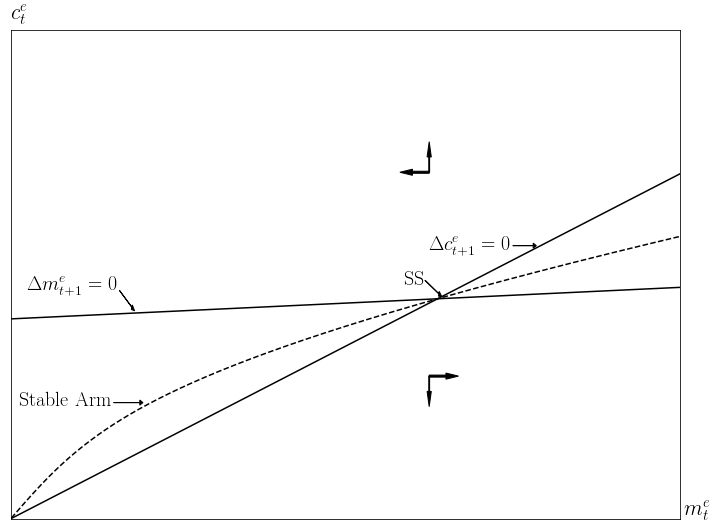

In [17]:
MyTBStype.solve()

UnempPrb = MyTBStype.UnempPrb
DiscFac = MyTBStype.DiscFac
R = MyTBStype.Rfree
PermGroFacCmp = MyTBStype.PermGroFacCmp
κ = MyTBStype.PFMPC
CRRA = MyTBStype.CRRA
Rnrm = MyTBStype.Rnrm
Pi = PiFunc(R, DiscFac, CRRA, UnempPrb, PermGroFacCmp)

# Define the range of mE to plot over
mE_range = np.linspace(0,8, 1000)
cE = MyTBStype.solution[0].cFunc(mE_range)

plt.figure(figsize=(12,9))
plt.plot(mE_range, mEDelEqZero(Rnrm, mE_range), 'k-') 
plt.plot(mE_range, cEDelEqZero(Rnrm, κ, Pi, mE_range), 'k-')
plt.plot(mE_range, cE, 'k--')   
plt.ylim(0, 2.4)
plt.xlim(0, 8)
plt.tick_params(labelbottom=False, labelleft=False,left='off',right='off',bottom='off',top='off')
plt.text(8.05,0,"$m_{t}^{e}$",fontsize = 22)
plt.text(0,2.43,"$c_{t}^{e}$",fontsize = 22)
plt.text(0.1,0.55,r'Stable Arm',fontsize = 20, fontweight='bold')
plt.text(0.2,1.1,r'$\Delta m_{t+1}^{e} = 0$',fontsize = 20, fontweight='bold')
plt.text(5,1.3,r'$\Delta c_{t+1}^{e} = 0$',fontsize = 20, fontweight='bold')
plt.text(4.7,1.15,r'SS',fontsize = 20, fontweight='bold')
plt.arrow(1.23,0.57,0.35,0,head_width= 0.025,width=0.001,facecolor='black',length_includes_head='True')
plt.arrow(1.3,1.12,0.18,-0.1,head_width= 0.025,width=0.001,facecolor='black',length_includes_head='True')
plt.arrow(6,1.34,0.28,0,head_width= 0.025,width=0.001,facecolor='black',length_includes_head='True')
plt.arrow(4.95,1.17,0.2,-0.08,head_width= 0.025,width=0.001,facecolor='black',length_includes_head='True')
plt.arrow(5,1.7,0,0.15,head_width= 0.05,width=0.01,facecolor='black',length_includes_head='True')
plt.arrow(5,1.7,-0.35,0,head_width= 0.03,head_length = 0.15,width=0.01,facecolor='black',length_includes_head='True')
plt.arrow(5,0.7,0,-0.15,head_width= 0.05,width=0.01,facecolor='black',length_includes_head='True')
plt.arrow(5,0.7,0.35,0,head_width= 0.03,head_length = 0.15,width=0.01,facecolor='black',length_includes_head='True')
if Generator:
    plt.savefig(os.path.join(Figures_HARK_dir, 'PhaseDiag.png'))
    plt.savefig(os.path.join(Figures_HARK_dir, 'PhaseDia.jpg'))
    plt.savefig(os.path.join(Figures_HARK_dir, 'PhaseDia.pdf'))
    plt.savefig(os.path.join(Figures_HARK_dir, 'PhaseDia.svg'))
if not in_ipynb:
    plt.show(block=False) 
else:
    plt.show(block=True)

### Figure 2: The Consumption Function for the Employed Consumer

Figure 2 shows the optimal consumption function $c(m)$ for an employed consumer (dropping the e superscript to reduce clutter). This is of course the stable arm of the phase diagram. Also plotted are the 45 degree line along which $c_{t} = m_{t}$ and

\begin{eqnarray*}
\bar{c}(m) &=&(m-1+h)κ^{u}, \\
\end{eqnarray*}

where

\begin{eqnarray*}
h &=&\left(\frac{1}{1- G/R}\right) \\
\end{eqnarray*}

is the level of (normalized) human wealth. $\bar{c}(m)$  is the solution to the no-risk version of the model; it is depicted in order to introduce another property of the model: As wealth approaches inﬁnity, the solution to the problem with risky labor income approaches the solution to the no-risk problem arbitrarily closely.

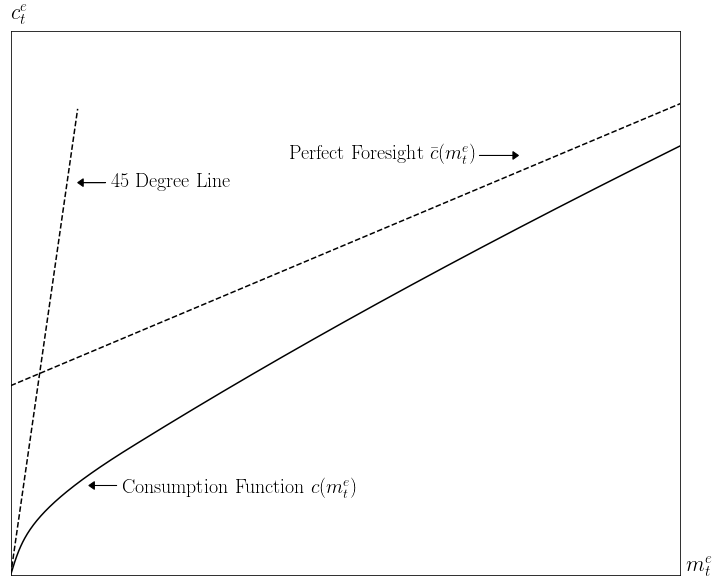

In [9]:
h = MyTBStype.h
def PerfForesightC(h, κ, mE):
    cE = (mE-1+h)*κ
    return cE

mE_range = np.linspace(0,60,1000)
mE_range1 = np.linspace(0,6,1000)
cE = MyTBStype.solution[0].cFunc(mE_range)
plt.figure(figsize=(12,10))
plt.plot(mE_range, PerfForesightC(h, κ, mE_range), 'k--') # Plot the first equation
plt.plot(mE_range, cE, 'k-')
plt.plot(mE_range1, mE_range1, 'k--')
plt.ylim(0, 7)
plt.xlim(0, 60)
plt.text(60.5,0,"$m_{t}^{e}$",fontsize = 22)
plt.text(0,7.1,"$c_{t}^{e}$",fontsize = 22)
plt.tick_params(labelbottom=False, labelleft=False,left='off',right='off',bottom='off',top='off')
plt.text(10,1,r'Consumption Function $c(m_{t}^{e})$',fontsize = 20, fontweight='bold')
plt.text(9,5,r'45 Degree Line',fontsize = 20, fontweight='bold')
plt.text(25,5.3,r'Perfect Foresight $\bar{c}(m_{t}^{e})$',fontsize = 20, fontweight='bold')
plt.arrow(8.5,5.05,-2.5,0,head_width= 0.1,head_length = 0.5,width=0.001,facecolor='black',length_includes_head='True')
plt.arrow(42,5.4,3.5,0,head_width= 0.1,head_length = 0.5,width=0.001,facecolor='black',length_includes_head='True')
plt.arrow(9.5,1.15,-2.5,0,head_width= 0.1,head_length = 0.5,width=0.001,facecolor='black',length_includes_head='True')
if Generator:
    plt.savefig(os.path.join(Figures_HARK_dir, 'cFunc.png'))
    plt.savefig(os.path.join(Figures_HARK_dir, 'cFunc.jpg'))
    plt.savefig(os.path.join(Figures_HARK_dir, 'cFunc.pdf'))
    plt.savefig(os.path.join(Figures_HARK_dir, 'cFunc.svg'))
if not in_ipynb:
    plt.show(block=False) 
else:
    plt.show(block=True)

### Figure 3 : Income and Consumption Growth

Figure 3 illustrates some of the key points in a diﬀerent way. It depicts the growth rate of consumption $c_{t+1}^{e} /c_{t}^{e}$ as a function of $m_{t}^{e}$.

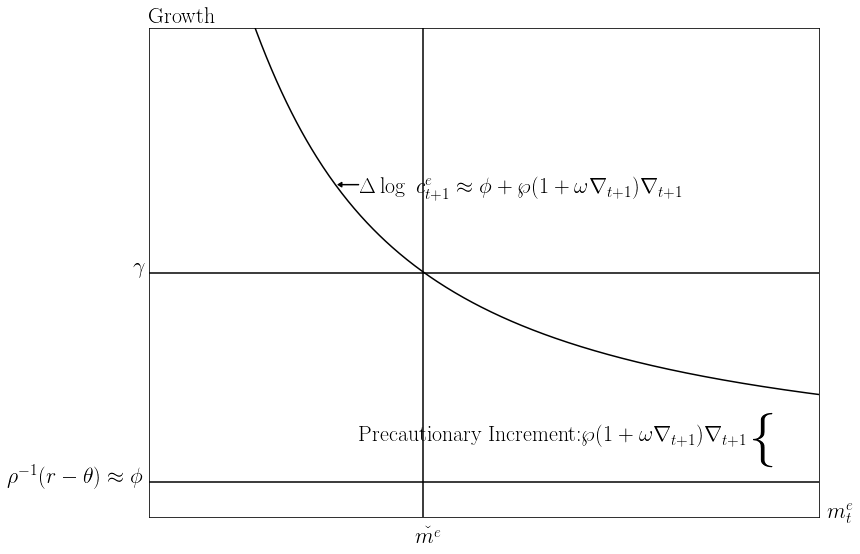

In [10]:
mE_range = np.linspace(0,15, 1000)
cE = MyTBStype.solution[0].cFunc(mE_range)
cU = MyTBStype.solution[0].cFunc_U(mE_range)
Nabla = (cE - cU)/cU
Omega = (CRRA - 1)/2
thorn = np.log((R*DiscFac)**(1/CRRA))
cEDelLog = thorn + UnempPrb*(1+ Nabla * Omega)*Nabla
#cEDelLog = np.log(((R*DiscFac)**(1/CRRA))*(1+UnempPrb*((cE/cU)**CRRA  - 1))**(1/CRRA))
idx = np.nanargmin(np.abs(cEDelLog-np.log(PermGroFacCmp)))
mTarg = mE_range[idx]
plt.figure(figsize=(12,9))
plt.plot(mE_range, cEDelLog,'k-')
plt.plot([0,8], [np.log(PermGroFacCmp),np.log(PermGroFacCmp)],'k-')
plt.plot([0,8], [thorn,thorn],'k-')
plt.plot([mTarg, mTarg],[-0.05,0.06],'k-')
plt.ylim(-0.04,0.06)
plt.xlim(0, 8)
plt.tick_params(labelbottom=False, labelleft=False,left='off',right='off',bottom='off',top='off')
plt.text(8.1,-0.041,"$m_{t}^{e}$",fontsize = 22)
plt.text(0,0.061,r'Growth',fontsize = 22)
plt.text(-0.2,np.log(PermGroFacCmp), r'$\gamma$',fontsize = 22)
plt.text(-1.7,thorn, r'$\rho^{-1}(r-\theta) \approx\phi$',fontsize = 22)
plt.text(mTarg-0.1,-0.045, r'$\check{m^{e}}$',fontsize = 22)
plt.text(2.5,0.025, r'$\Delta \log \  c_{t+1}^{e} \approx \phi + \wp(1 + \omega \nabla_{t+1})\nabla_{t+1} $',
         fontsize = 22)
plt.text(2.5,thorn +0.008, r'Precautionary Increment:$\wp(1 + \omega \nabla_{t+1})\nabla_{t+1}$',fontsize = 22)
plt.text(7.2,thorn +0.006, r'$\{$', fontsize = 55)
plt.arrow(2.5,0.028,-0.25,0,head_width= 0.001,head_length = 0.05,width=0.0001,facecolor='black',
          length_includes_head='True')
if Generator:
    plt.savefig(os.path.join(Figures_HARK_dir, 'GrowthA.png'))
    plt.savefig(os.path.join(Figures_HARK_dir, 'GrowthA.jpg'))
    plt.savefig(os.path.join(Figures_HARK_dir, 'GrowthA.pdf'))
    plt.savefig(os.path.join(Figures_HARK_dir, 'GrowthA.svg'))
if not in_ipynb:
    plt.show(block=False) 
else:
    plt.show(block=True)

### Figure 4 : The Effects of an Increase in the Interest Rate

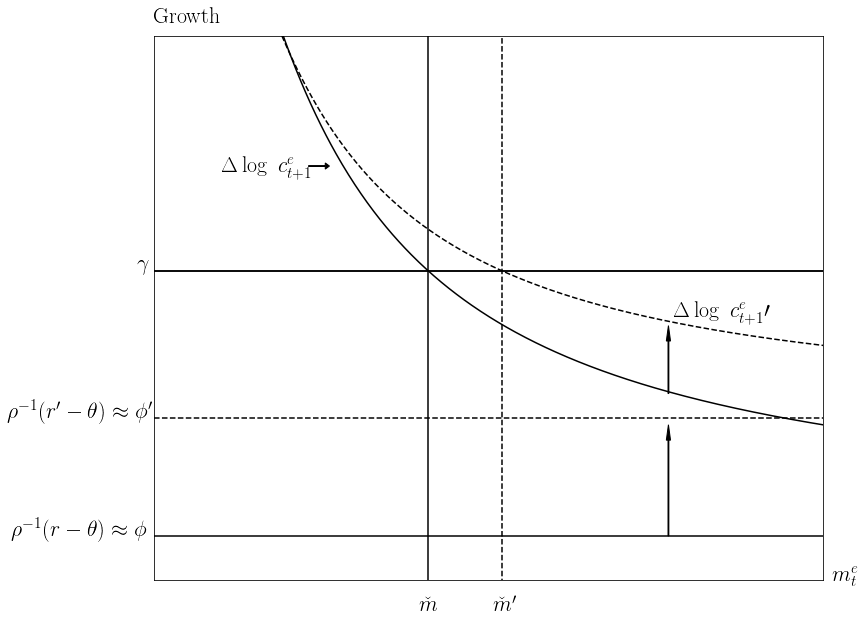

In [11]:
MyTBStype_1 = TractableConsumerType(**TBS_dictionary)
Rnew = MyTBStype.Rfree + 0.04
MyTBStype_1.Rfree = Rnew 
MyTBStype_1.solve()
UnempPrb_1 = MyTBStype_1.UnempPrb
DiscFac_1 = MyTBStype_1.DiscFac
R_1 = MyTBStype_1.Rfree
PermGroFacCmp_1 = MyTBStype_1.PermGroFacCmp
k_1 = MyTBStype_1.PFMPC
CRRA_1 = MyTBStype_1.CRRA
Rnrm_1 = MyTBStype_1.Rnrm
Pi_1 = PiFunc(R_1, DiscFac_1, CRRA_1, UnempPrb_1, PermGroFacCmp_1)
cEnew = MyTBStype_1.solution[0].cFunc(mE_range)
cUnew = MyTBStype_1.solution[0].cFunc_U(mE_range)
Nabla_1 = (cEnew - cUnew)/cUnew
Omega_1 = (CRRA_1 - 1)/2
thorn_1 = np.log((R_1*DiscFac_1)**(1/CRRA_1))
cEDelLognew = thorn_1 + UnempPrb_1*(1+ Nabla_1 * Omega_1)*Nabla_1
#cEDelLog = np.log(((R*DiscFac)**(1/CRRA))*(1+UnempPrb*((cE/cU)**CRRA  - 1))**(1/CRRA))
idx = np.nanargmin(np.abs(cEDelLognew-np.log(PermGroFacCmp_1)))
mTarg_1 = mE_range[idx]
plt.figure(figsize=(12,10))
plt.plot(mE_range, cEDelLog,'k-')
plt.plot(mE_range, cEDelLognew,'k--')
plt.plot([0,8], [np.log(PermGroFacCmp),np.log(PermGroFacCmp)],'k-')
plt.plot([0,8], [np.log(PermGroFacCmp_1),np.log(PermGroFacCmp_1)],'k-')
plt.plot([0,8], [thorn,thorn],'k-')
plt.plot([0,8], [thorn_1,thorn_1],'k--')
plt.plot([mTarg, mTarg],[-0.05,0.06],'k-')
plt.plot([mTarg_1, mTarg_1],[-0.05,0.06],'k--')
plt.ylim(-0.04,0.048)
plt.xlim(0, 8)
plt.text(8.1,-0.041,"$m_{t}^{e}$",fontsize = 22)
plt.text(0,0.05,r'Growth',fontsize = 22)
plt.tick_params(labelbottom=False, labelleft=False,left='off',right='off',bottom='off',top='off')
plt.text(-0.2,np.log(PermGroFacCmp), r'$\gamma$',fontsize = 22)
plt.text(-1.7,thorn, r'$\rho^{-1}(r-\theta) \approx\phi$',fontsize = 22)
plt.text(-1.75,thorn_1, r'$\rho^{-1}(r^{\prime}-\theta) \approx \phi^{\prime}$',fontsize = 22)
plt.text(mTarg-0.1,-0.045, r'$\check{m}$',fontsize = 22)
plt.text(mTarg_1-0.1,-0.045, r'$\check{m}^{\prime}$',fontsize = 22)
plt.text(0.8,0.025, r'$\Delta \log \  c_{t+1}^{e}$',fontsize = 22)
plt.text(6.2,0.0015, r'$\Delta \log \ c_{t+1}^{e} \prime$',fontsize = 22)
plt.arrow(1.85,0.027,0.25,0,head_width= 0.001,head_length = 0.05,width=0.0001,facecolor='black',
          length_includes_head='True')
plt.arrow(6.15,thorn,0,0.018,head_width= 0.05,head_length = 0.0025,width=0.01,facecolor='black',
          length_includes_head='True')
plt.arrow(6.15,thorn_1+0.004,0,0.011,head_width= 0.05,head_length = 0.0025,width=0.01,facecolor='black',
          length_includes_head='True')
if Generator:
    plt.savefig(os.path.join(Figures_HARK_dir, 'GrowthB.png'))
    plt.savefig(os.path.join(Figures_HARK_dir, 'GrowthB.jpg'))
    plt.savefig(os.path.join(Figures_HARK_dir, 'GrowthB.pdf'))
    plt.savefig(os.path.join(Figures_HARK_dir, 'GrowthB.svg'))
if not in_ipynb:
    plt.show(block=False) 
else:
    plt.show(block=True)

### Figure 5 : The Effects of an Increase in Unemployment Risk

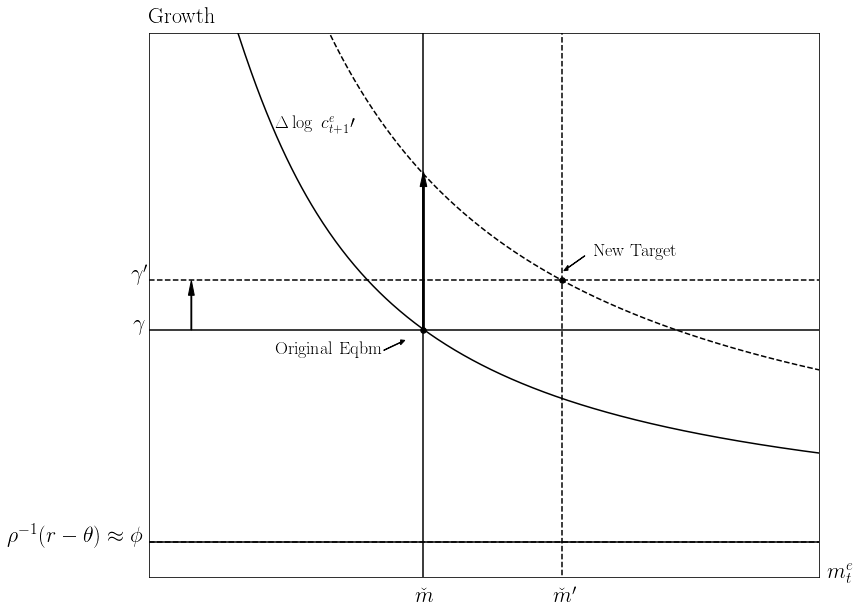

In [12]:
MyTBStype_2 = TractableConsumerType(**TBS_dictionary)
Unempnew = MyTBStype.UnempPrb * 3
MyTBStype_2.UnempPrb = Unempnew
MyTBStype_2.solve()
UnempPrb_2 = MyTBStype_2.UnempPrb
DiscFac_2 = MyTBStype_2.DiscFac
R_2 = MyTBStype_2.Rfree
PermGroFacCmp_2 = MyTBStype_2.PermGroFacCmp
k_2 = MyTBStype_2.PFMPC
CRRA_2 = MyTBStype_2.CRRA
Rnrm_2 = MyTBStype_2.Rnrm
#Pi_2 = PiFunc(R_2, DiscFac_2, CRRA_2, UnempPrb_2, PermGroFacCmp_2)
cEnew = MyTBStype_2.solution[0].cFunc(mE_range)
cUnew = MyTBStype_2.solution[0].cFunc_U(mE_range)
Nabla_2 = (cEnew - cUnew)/cUnew
Omega_2 = (CRRA - 1)/2
thorn_2 = np.log((R_2*DiscFac_2)**(1/CRRA_2))
cEDelLognew = thorn_2 + UnempPrb_2*(1+ Nabla_2 * Omega_2)*Nabla_2
#cEDelLog = np.log(((R*DiscFac)**(1/CRRA))*(1+UnempPrb*((cE/cU)**CRRA  - 1))**(1/CRRA))
idx = np.nanargmin(np.abs(cEDelLognew-np.log(PermGroFacCmp_2)))
mTarg_2 = mE_range[idx]
plt.figure(figsize=(12,10))
plt.plot(mE_range, cEDelLog,'k-')
plt.plot(mE_range, cEDelLognew,'k--')
plt.plot([0,8], [np.log(PermGroFacCmp),np.log(PermGroFacCmp)],'k-')
plt.plot([0,8], [np.log(PermGroFacCmp_2),np.log(PermGroFacCmp_2)],'k--')
plt.plot([0,8], [thorn,thorn],'k-')
plt.plot([0,8], [thorn_2,thorn_2],'k--')
plt.plot([mTarg, mTarg],[-0.05,0.07],'k-')
plt.plot([mTarg_2, mTarg_2],[-0.05,0.07],'k--')
plt.scatter(mTarg,np.log(PermGroFacCmp), color = 'k', s = 30)
plt.scatter(mTarg_2,np.log(PermGroFacCmp_2), color = 'k', s = 30)
plt.ylim(-0.04,0.07)
plt.xlim(0, 8)
plt.text(8.1,-0.041,"$m_{t}^{e}$",fontsize = 22)
plt.text(0,0.072,r'Growth',fontsize = 22)
plt.tick_params(labelbottom=False, labelleft=False,left='off',right='off',bottom='off',top='off')
plt.text(-0.2,np.log(PermGroFacCmp), r'$\gamma$',fontsize = 22)
plt.text(-0.22,np.log(PermGroFacCmp_2), r'$\gamma^{\prime}$',fontsize = 22)
plt.text(-1.7,thorn, r'$\rho^{-1}(r-\theta) \approx\phi$',fontsize = 22)
plt.text(mTarg-0.1,-0.045, r'$\check{m}$',fontsize = 22)
plt.text(mTarg_2-0.1,-0.045, r'$\check{m}^{\prime}$',fontsize = 22)
plt.text(1.5,0.05, r'$\Delta \log \ c_{t+1}^{e} \prime$',fontsize = 18)
plt.text(1.5,0.005, r'Original Eqbm',fontsize = 18)
plt.text(5.3,0.025, r'New Target',fontsize = 18)
plt.arrow(2.8,0.0059,0.25,0.002,head_width= 0.001,head_length = 0.05,width=0.0001,facecolor='black',
          length_includes_head='True')
plt.arrow(5.2,0.025,-0.25,-0.003,head_width= 0.001,head_length = 0.05,width=0.0001,facecolor='black',
          length_includes_head='True')
plt.arrow(0.5,np.log(PermGroFacCmp),0,0.01,head_width= 0.07,head_length = 0.003,width=0.01,facecolor='black',
          length_includes_head='True')
plt.arrow(mTarg,np.log(PermGroFacCmp),0,0.032,head_width= 0.08,head_length = 0.003,width=0.02,facecolor='black',
          length_includes_head='True')

if Generator:
    plt.savefig(os.path.join(Figures_HARK_dir, 'cGroIncreaseMhoPlot.png'))
    plt.savefig(os.path.join(Figures_HARK_dir, 'cGroIncreaseMhoPlot.jpg'))
    plt.savefig(os.path.join(Figures_HARK_dir, 'cGroIncreaseMhoPlot.pdf'))
    plt.savefig(os.path.join(Figures_HARK_dir, 'cGroIncreaseMhoPlot.svg'))
if not in_ipynb:
    plt.show(block=False) 
else:
    plt.show(block=True)

### Figure 6: The Effects of Lower $\theta$ On Consumption Function

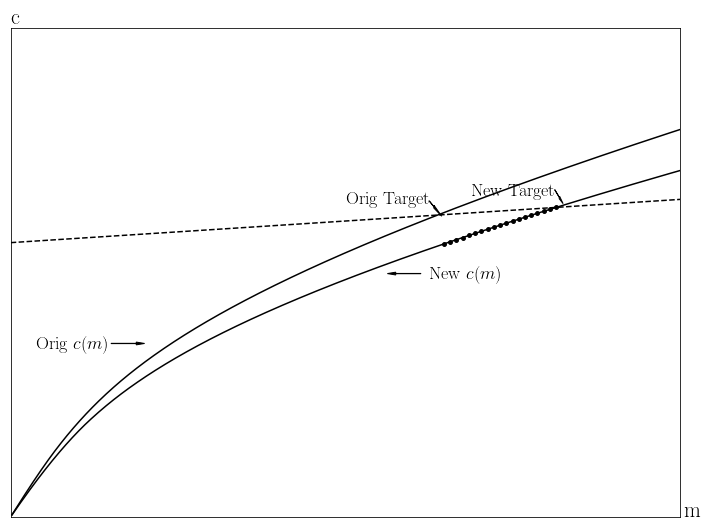

In [13]:
MyTBStype_3 = TractableConsumerType(**TBS_dictionary)
DiscFacnew = (1/(1.1-0.02))
MyTBStype_3.DiscFac = DiscFacnew
MyTBStype_3.solve()
UnempPrb_3 = MyTBStype_3.UnempPrb
DiscFac_3 = MyTBStype_3.DiscFac
R_3 = MyTBStype_3.Rfree
PermGroFacCmp_3 = MyTBStype_3.PermGroFacCmp
k_3 = MyTBStype_3.PFMPC
CRRA_3 = MyTBStype_3.CRRA
Rnrm_3 = MyTBStype_3.Rnrm
Pi_3 = PiFunc(R_3, DiscFac_3, CRRA_3, UnempPrb_3, PermGroFacCmp_3)

mE_range = np.linspace(0,15,1000)
cEnew = MyTBStype_3.solution[0].cFunc(mE_range)
mE_scatter = np.linspace(MyTBStype.mTarg,MyTBStype_3.mTarg, 20)
scatter_cE = MyTBStype_3.solution[0].cFunc(mE_scatter[1:])
plt.figure(figsize=(12,9))
plt.plot(mE_range, mEDelEqZero(Rnrm_3, mE_range), 'k--') 
plt.plot(mE_range, cE, 'k-') 
plt.plot(mE_range, cEnew, 'k-')
plt.scatter(mE_scatter[1:], scatter_cE, color = 'k', s =15)
plt.ylim(0, 1.75)
plt.xlim(0, 8)
plt.text(8.05,0,r'm', fontsize = 22)
plt.text(0,1.765,r'c', fontsize = 22)
plt.tick_params(labelbottom=False, labelleft=False,left='off',right='off',bottom='off',top='off')
plt.text(0.3,0.6, r'Orig $c(m)$',fontsize = 18)
plt.text(5,0.85, r'New $c(m)$',fontsize = 18)
plt.text(4,1.12, r'Orig Target',fontsize = 18)
plt.text(5.5,1.15, r'New Target',fontsize = 18)
plt.arrow(1.2,0.62,0.4,0,head_width= 0.01,head_length = 0.1,width=0.001,facecolor='black',
          length_includes_head='True')
plt.arrow(4.9,0.87,-0.4,0,head_width= 0.01,head_length = 0.1,width=0.001,facecolor='black',
          length_includes_head='True')
plt.arrow(5,1.13,0.15,-0.055,head_width= 0.01,head_length = 0.1,width=0.001,facecolor='black',
          length_includes_head='True')
plt.arrow(6.5,1.17,0.1,-0.05,head_width= 0.01,head_length = 0.05,width=0.001,facecolor='black',
          length_includes_head='True')
if Generator:
    plt.savefig(os.path.join(Figures_HARK_dir, 'PhaseDiagramDecreaseThetaPlot.png'))
    plt.savefig(os.path.join(Figures_HARK_dir, 'PhaseDiagramDecreaseThetaPlot.jpg'))
    plt.savefig(os.path.join(Figures_HARK_dir, 'PhaseDiagramDecreaseThetaPlot.pdf'))
    plt.savefig(os.path.join(Figures_HARK_dir, 'PhaseDiagramDecreaseThetaPlot.svg'))
if not in_ipynb:
    plt.show(block=False) 
else:
    plt.show(block=True)

### Figure 7: Path of $c^{e}$ Before and After $\theta$ Decline

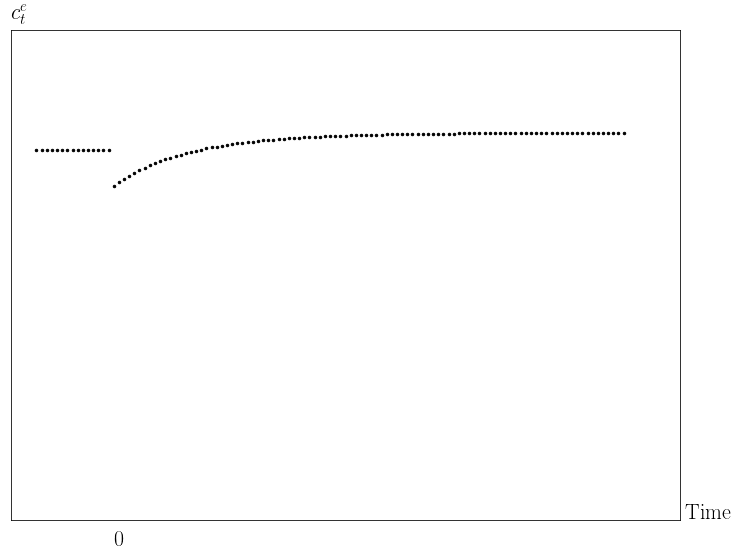

In [14]:
MyTBStype.T_sim = 100
MyTBStype.aLvlInitMean = 1.
MyTBStype.aLvlInitStd = 0.
MyTBStype.track_vars = ['mLvlNow','cLvlNow']
MyTBStype.initializeSim()
MyTBStype.simulate()

# Capture steady states
sscE = MyTBStype.cLvlNow
ssmE = MyTBStype.mLvlNow

# Now lets change the discount factor from 0.96 to 0.97
#MyTBStype.DiscFac = MyTBStype_3.DiscFac
MyTBStype_3.solve() #remember to resolve the consumer's problem
MyTBStype_3.T_sim = 110
MyTBStype_3.aLvlInitMean = 1.
MyTBStype_3.aLvlInitStd = 0.
MyTBStype_3.track_vars = ['mLvlNow','cLvlNow']
MyTBStype_3.initializeSim()
MyTBStype_3.simulate()

# Organise the data into a impulse response plot
TimePeriod = np.arange(-5, 110, 1)

cE = np.zeros((115,1))
cE[:15,:] = sscE
cE[15:,:] = MyTBStype_3.cLvlNow_hist[10:]

mE = np.zeros((115,1))
mE[:15,:] = ssmE
mE[15:,:] = MyTBStype_3.mLvlNow_hist[10:]

plt.figure(figsize=(12,9))
plt.scatter(TimePeriod, cE,  color = 'k', s =6)
plt.ylim(0,1.5)
plt.xlim(-10, 120)
plt.tick_params(labelbottom=False, labelleft=False,left='off',right='off',bottom='off',top='off')
plt.text(121,0, r'Time', fontsize = 22)
plt.text(-10,1.52, r'$c_{t}^{e}$', fontsize = 22)
plt.text(10,-0.08, r'0', fontsize = 22)
if Generator:
    plt.savefig(os.path.join(Figures_HARK_dir, 'cPathAfterThetaDrop.png'))
    plt.savefig(os.path.join(Figures_HARK_dir, 'cPathAfterThetaDrop.jpg'))
    plt.savefig(os.path.join(Figures_HARK_dir, 'cPathAfterThetaDrop.pdf'))
    plt.savefig(os.path.join(Figures_HARK_dir, 'cPathAfterThetaDrop.svg'))
if not in_ipynb:
    plt.show(block=False) 
else:
    plt.show(block=True)

### Figure 8 : Path of $m^{e}$ Before and After $\theta$ Decline

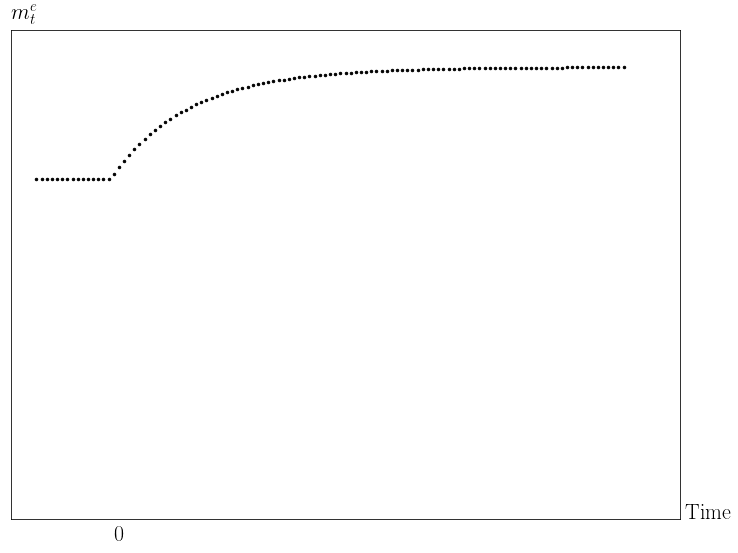

In [15]:
plt.figure(figsize=(12,9))
plt.scatter(TimePeriod, mE, color = 'k',s =6)
plt.text(121,0, r'Time', fontsize = 22)
plt.tick_params(labelbottom=False, labelleft=False,left='off',right='off',bottom='off',top='off')
plt.text(-10,8.1, r'$m_{t}^{e}$', fontsize = 22)
plt.text(10,-0.35, r'0', fontsize = 22)
plt.ylim(0,8)
plt.xlim(-10, 120)
if Generator:
    plt.savefig(os.path.join(Figures_HARK_dir, 'mPathAfterThetaDrop.png'))
    plt.savefig(os.path.join(Figures_HARK_dir, 'mPathAfterThetaDrop.jpg'))
    plt.savefig(os.path.join(Figures_HARK_dir, 'mPathAfterThetaDrop.pdf'))
    plt.savefig(os.path.join(Figures_HARK_dir, 'mPathAfterThetaDrop.svg'))
if not in_ipynb:
    plt.show(block=False) 
else:
    plt.show(block=True)

### Figure 9 : Marginal Propensity to Consume $\kappa_{t}$ Before and After $\theta$ Decline

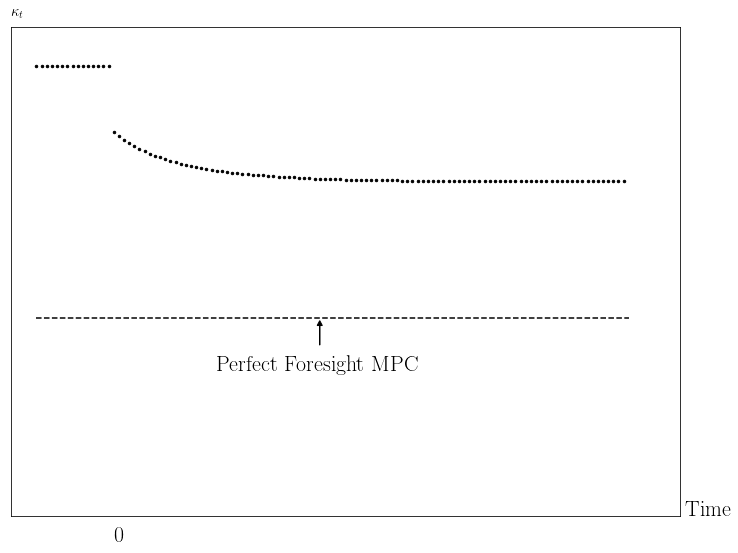

In [16]:
MPC = np.zeros((115,1))
MPC[:15,:] = MyTBStype.solution[0].cFunc.eval_with_derivative(ssmE)[1]
MPC[15:,:] = MyTBStype_3.solution[0].cFunc.eval_with_derivative(MyTBStype_3.mLvlNow_hist)[1][10:]

plt.figure(figsize=(12,9))
plt.scatter(TimePeriod, MPC,  color = 'k', s =6)
plt.plot([-5,110], [MyTBStype.PFMPC,MyTBStype.PFMPC], '--k')
plt.text(121,0.02, r'Time', fontsize = 22)
plt.tick_params(labelbottom=False, labelleft=False,left='off',right='off',bottom='off',top='off')
plt.text(-10,0.122, r'$\kappa_{t}$', fontsize = 15)
plt.text(10,0.015, r'0', fontsize = 22)
plt.ylim(0.02,0.12)
plt.xlim(-10, 120)
plt.text(30,0.05, r'Perfect Foresight MPC', fontsize = 22)
plt.arrow(50,0.055,0,0.005,head_width= 1,head_length = 0.001,width=0.001,facecolor='black',
          length_includes_head='True')
if Generator:
    plt.savefig(os.path.join(Figures_HARK_dir, 'MPCPathAfterThetaDrop.png'))
    plt.savefig(os.path.join(Figures_HARK_dir, 'MPCPathAfterThetaDrop.jpg'))
    plt.savefig(os.path.join(Figures_HARK_dir, 'MPCPathAfterThetaDrop.pdf'))
    plt.savefig(os.path.join(Figures_HARK_dir, 'MPCPathAfterThetaDrop.svg'))
if not in_ipynb:
    plt.show(block=False) 
else:
    plt.show(block=True)